# Stress Detection on WESAD (Wrist-Only): End-to-End, Reproducible, and Android-Ready

This notebook trains and validates a **Random Forest** classifier for **wrist-only** stress detection using the WESAD dataset, exporting a production-ready **ONNX** model (`stress_model.onnx`) compatible with the Android app. It follows reproducible ML practice, includes rigorous evaluation (confusion matrices, ROC/PR curves, calibration, and learning curves), and preserves feature order and standardization used during training for correct on-device inference.


## Cell 1 — Environment, Paths, and Dependencies

**Goal.** Initialize the environment; define canonical project paths and imports; ensure the `utils/` folder (containing our fixed `preprocessing.py`) is importable.

**What this cell does**
- Imports all scientific Python libraries required for preprocessing, modeling, evaluation, and ONNX export.
- Constructs absolute paths for:
  - `ROOT` (project root),
  - `UTILS/` (contains `preprocessing.py`),
  - `PREPROCESSED/` (where intermediate artifacts will be stored),
  - `MODELS/` (where trained models and scalers are saved).
- Creates missing folders to guarantee the notebook is runnable from scratch.

**Why it matters**
- Consistent, absolute paths avoid fragile relative‐path bugs.
- Declaring dependencies at the start improves reproducibility and peer review.

**Outputs**
- Console echo of resolved paths to confirm the layout.


In [18]:
# Cell 1 — Setup
import os, sys, json, pickle, shutil, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
# Displays & metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.utils.class_weight import compute_class_weight

# ONNX export & runtime
import onnx
import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Paths
ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
UTILS = ROOT / "utils"
PREPROC = ROOT / "preprocessed"
MODELS = ROOT / "models"

PREPROC.mkdir(exist_ok=True)
MODELS.mkdir(exist_ok=True)

# Make utils importable
if str(UTILS.parent) not in sys.path:
    sys.path.insert(0, str(UTILS.parent))

print("ROOT:", ROOT)
print("UTILS:", UTILS)
print("PREPROC:", PREPROC)
print("MODELS:", MODELS)


ROOT: C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel
UTILS: C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\utils
PREPROC: C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\preprocessed
MODELS: C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\models


## Cell 2 — Run Wrist-Only Preprocessing (30-s Windows, Label-Stream Mode, Purity Filter)

**Goal.** Generate model-ready features/labels using a scientifically consistent pipeline **aligned with WESAD protocol**:
- **Windowing:** fixed 30-s non-overlapping windows.
- **Labeling:** **mode** of the 700 Hz `label` stream within each window.
- **Purity:** discard boundary windows where the dominant label occupies < 80% of samples.
- **Signals:** wrist ACC (x,y,z), TEMP, BVP; **no chest** signals.
- **Alignment:** all streams placed on a common time axis before feature extraction.
- **Features:** 10 total, in this exact order:
  1. `acc_x_mean, acc_y_mean, acc_z_mean, temp_mean, bvp_mean`
  2. `acc_x_std,  acc_y_std,  acc_z_std,  temp_std,  bvp_std`

**What this cell does**
- Invokes `utils/preprocessing.py:main()` to build `X.npy`, `y.npy`, and `feature_scaler.pkl` in `preprocessed/`.
- Loads the saved artifacts to verify shapes, class distribution, and feature order.

**Why it matters**
- Using the **label stream** instead of `*_quest.csv` timestamps prevents mislabeling from clock drift and window boundary issues.
- 30-s windows stabilize physiology; 1-s windows tend to look “baseline-ish” and degrade separability.

**Outputs**
- `preprocessed/X.npy` (float32/float64, shape `[N, 10]`)
- `preprocessed/y.npy` (int labels in `{0: amusement, 1: baseline, 2: stress}`)
- `preprocessed/feature_scaler.pkl` (global means/stds over the entire dataset; **for EDA only**, not used in training to avoid leakage)
- Console readout of shapes, label counts, and feature order.

In [19]:
# Cell 2 — Run the fixed preprocessing and save where we want
import utils.preprocessing as prep

# 1) Reload to pick up latest code first
importlib.reload(prep)

# 2) Now override output TARGETS (after reload!). 
#    Put npy files in preprocessed/, scaler .pkl in models/
prep.OUT_X = str((PREPROC / "X.npy").resolve())
prep.OUT_Y = str((PREPROC / "y.npy").resolve())
prep.OUT_SCALER = str((MODELS / "feature_scaler.pkl").resolve())

# 3) Make sure target dirs exist
os.makedirs(PREPROC, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)

# 4) Run preprocessing
prep.main()

# 5) Verify from the exact target paths
X = np.load(PREPROC / "X.npy")
y = np.load(PREPROC / "y.npy")
with open(MODELS / "feature_scaler.pkl", "rb") as f:
    scaler_all = pickle.load(f)

print("X shape:", X.shape, "y shape:", y.shape)
print("Label counts:", np.bincount(y, minlength=3))
print("Feature order:", scaler_all["feature_order"])
print("Scaler saved at:", (MODELS / "feature_scaler.pkl").resolve())


S2: X(162, 10), y(162,), dist=[105  37  20]
S3: X(173, 10), y(173,), dist=[115  37  21]
S4: X(172, 10), y(172,), dist=[114  38  20]
S5: X(168, 10), y(168,), dist=[108  39  21]
S6: X(196, 10), y(196,), dist=[137  38  21]
S7: X(134, 10), y(134,), dist=[75 39 20]
S8: X(142, 10), y(142,), dist=[82 38 22]
S9: X(133, 10), y(133,), dist=[73 39 21]
S10: X(141, 10), y(141,), dist=[79 39 23]
S11: X(135, 10), y(135,), dist=[74 39 22]
S13: X(143, 10), y(143,), dist=[82 39 22]
S14: X(143, 10), y(143,), dist=[82 39 22]
S15: X(135, 10), y(135,), dist=[74 39 22]
S16: X(145, 10), y(145,), dist=[86 38 21]
S17: X(160, 10), y(160,), dist=[97 39 24]

Saved: C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\preprocessed\X.npy (shape (2282, 10)), C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\preprocessed\y.npy (shape (2282,))
Saved: C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\models\feature_scaler.pkl
Label distribution: {0: 1383, 1: 57

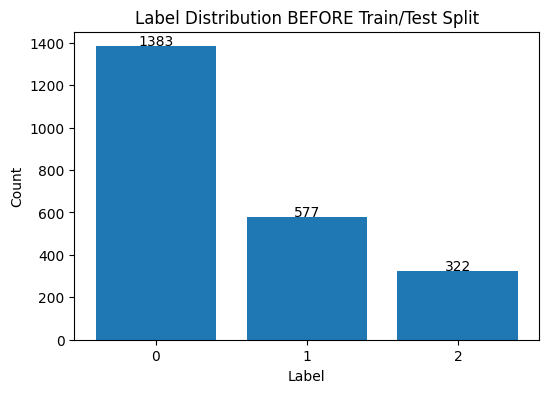

BEFORE split - Label counts: {0: 1383, 1: 577, 2: 322}


In [20]:
# === Visualize label distribution BEFORE split ===


unique_labels, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique_labels, counts, tick_label=[str(l) for l in unique_labels])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution BEFORE Train/Test Split")
for i, count in enumerate(counts):
    plt.text(unique_labels[i], count + 5, str(count), ha='center', fontsize=10)
plt.show()

print("BEFORE split - Label counts:", dict(zip(unique_labels, counts)))


## Cell 3 — Stratified Train/Validation/Test Split + Train-Only Standardization

**Goal.** Create generalizable evaluation splits and compute **standardization parameters from the training set only** to avoid information leakage.

**What this cell does**
- Splits data into **70% train**, **15% validation**, **15% test** with stratification.
- Fits a `StandardScaler` on the **training** subset only; transforms val/test with those parameters.
- Saves a **train-only** scaler to `models/feature_scaler_train.pkl` containing:
  - `means`, `stds` (length 10),
  - `feature_order`,
  - window and purity metadata for traceability.

**Why it matters**
- The Android app must standardize using **exactly these train-only stats** for fidelity with the model.

**Outputs**
- `models/feature_scaler_train.pkl` (the one Android code should use)
- Printed shapes and label distributions for all splits.


In [21]:
# Cell 3 — Stratified splits and scaler (train-only)
# 70/15/15 split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)  # 0.1765 of 85% ≈ 15%

# Standardize with train-only stats (so Android must use these stats at inference)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Save the train-only scaler so Android matches training exactly
scaler_train = {
    "means": scaler.mean_.astype(float),
    "stds":  scaler.scale_.astype(float),
    "feature_order": scaler_all["feature_order"],
    "win_sec": scaler_all["win_sec"],
    "purity": scaler_all["purity"],
}
with open(MODELS / "feature_scaler_train.pkl", "wb") as f:
    pickle.dump(scaler_train, f)

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)
print("Train label dist:", np.bincount(y_train, minlength=3))
print("Saved train-only scaler →", MODELS / "feature_scaler_train.pkl")


Train/Val/Test: (1596, 10) (343, 10) (343, 10)
Train label dist: [967 403 226]
Saved train-only scaler → C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\models\feature_scaler_train.pkl


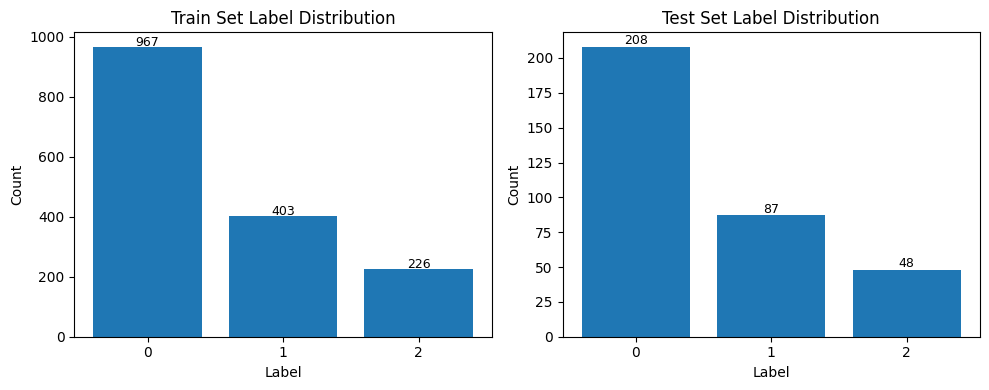

AFTER split - Train label counts: {0: 967, 1: 403, 2: 226}
AFTER split - Test label counts: {0: 208, 1: 87, 2: 48}


In [22]:
# === Visualize label distribution AFTER split ===
def plot_label_distribution(y_data, title):
    unique_labels, counts = np.unique(y_data, return_counts=True)
    plt.bar(unique_labels, counts, tick_label=[str(l) for l in unique_labels])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(title)
    for i, count in enumerate(counts):
        plt.text(unique_labels[i], count + 2, str(count), ha='center', fontsize=9)

plt.figure(figsize=(10,4))

# Train distribution
plt.subplot(1, 2, 1)
plot_label_distribution(y_train, "Train Set Label Distribution")

# Test distribution
plt.subplot(1, 2, 2)
plot_label_distribution(y_test, "Test Set Label Distribution")

plt.tight_layout()
plt.show()

print("AFTER split - Train label counts:", dict(zip(*np.unique(y_train, return_counts=True))))
print("AFTER split - Test label counts:", dict(zip(*np.unique(y_test, return_counts=True))))


In [24]:
# === Load train-only scaler for Android integration ===
import joblib
import numpy as np

# Path to the saved train-only scaler
scaler_path = "../models/feature_scaler_train.pkl"

# Load the scaler object
scaler_data = joblib.load(scaler_path)

# Extract means and stds
means = np.array(scaler_data["means"], dtype=np.float32)
stds = np.array(scaler_data["stds"], dtype=np.float32)

# Print in Java array format for direct copy-paste
print("Means array for Java:\n", ", ".join(f"{m:.8f}f" for m in means))
print("\nStds array for Java:\n", ", ".join(f"{s:.8f}f" for s in stds))

# Also show with Python formatting (for sanity check)
print("\nMeans (Python):", means)
print("Stds (Python):", stds)

# Print feature order to ensure Android matches training
if "feature_order" in scaler_data:
    print("\nFeature order:", scaler_data["feature_order"])
else:
    print("\n⚠ No feature_order key found; double-check preprocessing.py saved it.")


Means array for Java:
 10.29446888f, -2.68146610f, 17.71344376f, 32.70376205f, 0.03583246f, 7.64594269f, 8.24621105f, 10.22108555f, 0.02311826f, 56.15372849f

Stds array for Java:
 41.47072220f, 26.64478111f, 27.80905151f, 1.47868752f, 1.05989313f, 7.00220728f, 9.34066677f, 9.21833134f, 0.01729131f, 41.47352600f

Means (Python): [ 1.0294469e+01 -2.6814661e+00  1.7713444e+01  3.2703762e+01
  3.5832465e-02  7.6459427e+00  8.2462111e+00  1.0221086e+01
  2.3118258e-02  5.6153728e+01]
Stds (Python): [4.1470722e+01 2.6644781e+01 2.7809052e+01 1.4786875e+00 1.0598931e+00
 7.0022073e+00 9.3406668e+00 9.2183313e+00 1.7291309e-02 4.1473526e+01]

Feature order: ['acc_x_mean', 'acc_y_mean', 'acc_z_mean', 'temp_mean', 'bvp_mean', 'acc_x_std', 'acc_y_std', 'acc_z_std', 'temp_std', 'bvp_std']


## Cell 4 — Random Forest (Class-Balanced) Training

**Goal.** Train a **Random Forest** tuned for robustness under class imbalance and noisy wrist signals, consistent with the 2018 WESAD findings that tree ensembles perform strongly.

**What this cell does**
- Instantiates `RandomForestClassifier` with:
  - `class_weight="balanced"` to counter baseline dominance,
  - higher `n_estimators` for variance reduction,
  - moderate `max_depth` and `min_samples_leaf` for generalization.
- Fits on standardized training data, prints quick validation (and peeking test) accuracies.

**Why it matters**
- Wrist-only stress detection is challenging; forests handle heterogeneous feature relevance and non-linear boundaries.

**Outputs**
- Trained `rf` estimator in memory.
- Validation accuracy; a preliminary test accuracy (for sanity only—final reporting happens later).


In [25]:
# Cell 4 — Model definition & quick tuning
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=18,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_s, y_train)

print("Val accuracy:", rf.score(X_val_s, y_val))
print("Test (peeking, not final) accuracy:", rf.score(X_test_s, y_test))


Val accuracy: 0.8309037900874635
Test (peeking, not final) accuracy: 0.8250728862973761


## Cell 5 — Classification Reports & Confusion Matrices (Val & Test)

**Goal.** Provide detailed per-class performance: precision, recall, F1, and error structure.

**What this cell does**
- Computes `classification_report` for validation and test splits.
- Plots confusion matrices to visualize which classes are confused (e.g., stress vs. baseline).

**Why it matters**
- For safety-critical affect inference, **recall** on stress matters; confusion matrices reveal whether false negatives or false positives dominate.

**Outputs**
- Text reports (macro/weighted F1)
- Two confusion matrix figures (validation and test)



=== Validation Classification Report ===
              precision    recall  f1-score   support

           0     0.8584    0.9038    0.8806       208
           1     0.7821    0.7011    0.7394        87
           2     0.7826    0.7500    0.7660        48

    accuracy                         0.8309       343
   macro avg     0.8077    0.7850    0.7953       343
weighted avg     0.8285    0.8309    0.8287       343

=== Test Classification Report ===
              precision    recall  f1-score   support

           0     0.8386    0.8990    0.8677       208
           1     0.7805    0.7356    0.7574        87
           2     0.8421    0.6667    0.7442        48

    accuracy                         0.8251       343
   macro avg     0.8204    0.7671    0.7898       343
weighted avg     0.8243    0.8251    0.8225       343



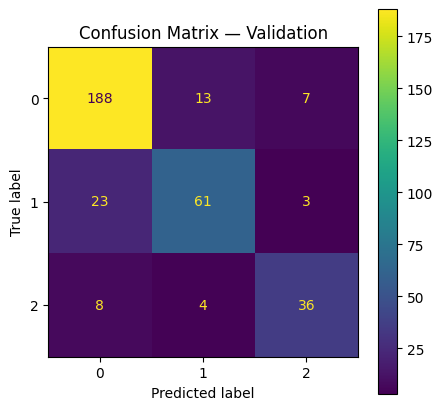

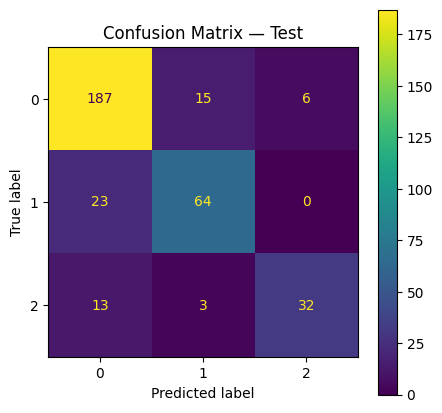

In [26]:
# Cell 5 — Classification report & confusion matrices
y_val_pred = rf.predict(X_val_s)
y_test_pred = rf.predict(X_test_s)

print("=== Validation Classification Report ===")
print(classification_report(y_val, y_val_pred, digits=4))

print("=== Test Classification Report ===")
print(classification_report(y_test, y_test_pred, digits=4))

fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=ax)
ax.set_title("Confusion Matrix — Validation")
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax)
ax.set_title("Confusion Matrix — Test")
plt.show()


## Cell 6 — ROC and Precision–Recall (OvR) Curves (Validation)

**Goal.** Assess discriminability under class imbalance using threshold-free metrics (AUC) and **Precision–Recall**, which is more informative for rare classes.

**What this cell does**
- Plots **ROC** per class (One-vs-Rest) with AUC.
- Plots **Precision–Recall** per class with Average Precision (AP).

**Why it matters**
- For imbalanced datasets, PR curves better reflect practical detection utility than ROC alone (precision vs. recall trade-off for stress alerts).

**Outputs**
- ROC and PR plots for validation data, with AUC/AP annotations.


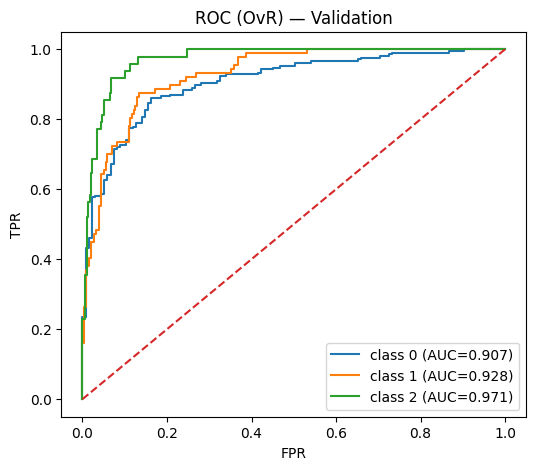

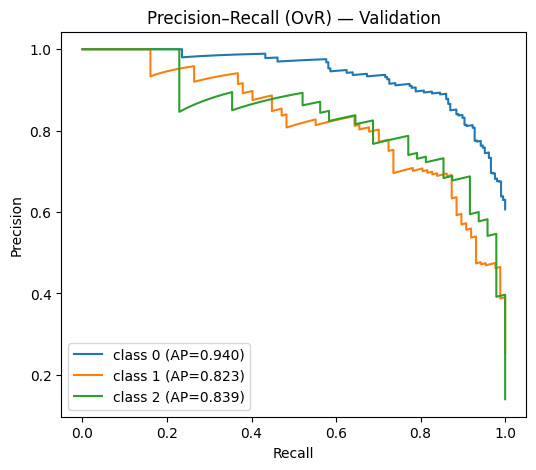

In [27]:
# Cell 6 — ROC (OvR) and PR curves
n_classes = len(np.unique(y))
y_val_proba = rf.predict_proba(X_val_s)
y_test_proba = rf.predict_proba(X_test_s)

# One-vs-Rest binarization
def binarize(y, c):
    return (y == c).astype(int)

# ROC
plt.figure(figsize=(6,5))
for c in range(n_classes):
    fpr, tpr, _ = roc_curve(binarize(y_val, c), y_val_proba[:, c])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"class {c} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (OvR) — Validation"); plt.legend()
plt.show()

# PR
plt.figure(figsize=(6,5))
for c in range(n_classes):
    prec, rec, _ = precision_recall_curve(binarize(y_val, c), y_val_proba[:, c])
    ap = average_precision_score(binarize(y_val, c), y_val_proba[:, c])
    plt.plot(rec, prec, label=f"class {c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (OvR) — Validation"); plt.legend()
plt.show()


## Cell 7 — Calibration Curve (Validation)

**Goal.** Evaluate how well the model’s max-class probabilities correspond to empirical correctness (probability calibration).

**What this cell does**
- Builds a calibration plot comparing predicted confidence vs. actual accuracy in bins.

**Why it matters**
- Overconfident but wrong predictions can be harmful in UX (e.g., frequent false stress alarms); calibration helps set thresholds or smoothing in the app.

**Outputs**
- A reliability diagram (calibration plot) on validation data.




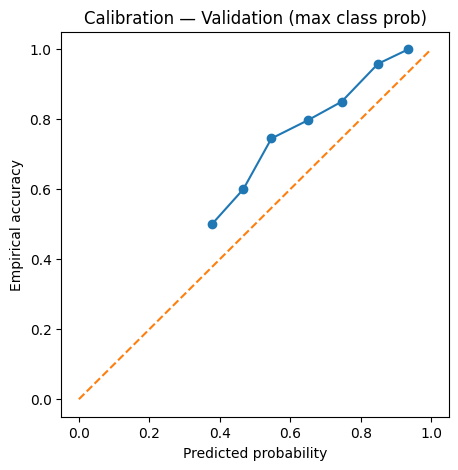

In [28]:
# Cell 7 — Calibration curve (overall)
probs = np.max(y_val_proba, axis=1)  # confidence of chosen class
true_pos = (y_val_pred == y_val).astype(int)
prob_true, prob_pred = calibration_curve(true_pos, probs, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted probability"); plt.ylabel("Empirical accuracy")
plt.title("Calibration — Validation (max class prob)")
plt.show()


## Cell 8 — Learning Curve (Bias/Variance Sanity Check)

**Goal.** Diagnose whether adding more data or simplifying the model is likely to help.

**What this cell does**
- Computes accuracy curves over increasing fractions of training data under stratified CV.

**Why it matters**
- If training and CV curves converge high → we are near data/parameter sufficiency.
- If gap remains large → more data or stronger regularization may help.

**Outputs**
- Learning curve figure showing train vs. cross-validation accuracy vs. sample size.


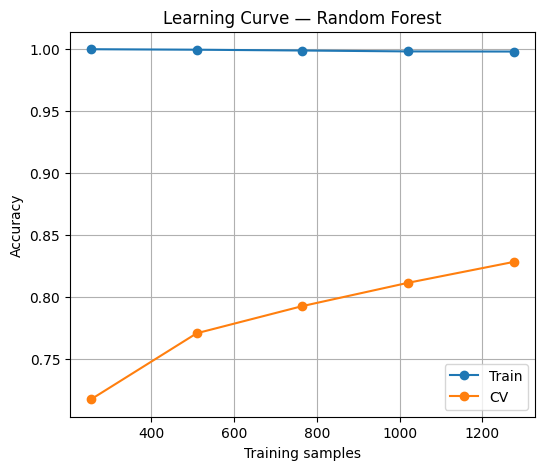

In [29]:
# Cell 8 — Learning curve (sanity on data sufficiency)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, val_scores = learning_curve(
    rf, X_train_s, y_train, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.2, 1.0, 5), scoring="accuracy"
)
plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='CV')
plt.xlabel("Training samples"); plt.ylabel("Accuracy")
plt.title("Learning Curve — Random Forest")
plt.legend(); plt.grid(True)
plt.show()


## Cell 9 — Feature Importances

**Goal.** Provide model introspection for scientific reporting and engineering decisions.

**What this cell does**
- Extracts and plots Random Forest feature importances ranked descending.
- Prints a table for easy copy-paste in reports.

**Why it matters**
- Helps validate whether physiologically plausible features (e.g., ACC dynamics, TEMP variation, BVP mean/std) drive decisions.

**Outputs**
- Bar plot of importances and a sorted DataFrame.


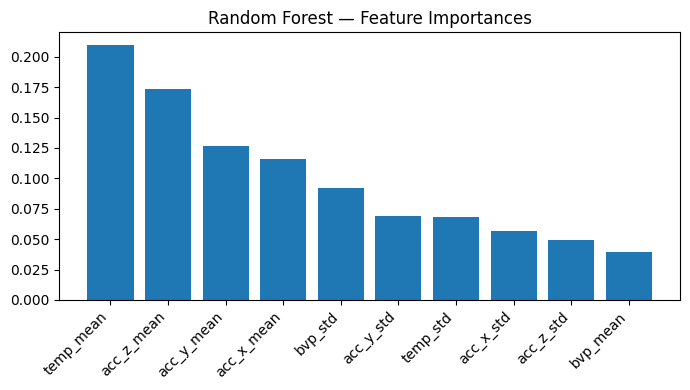

,feature,importance
3,temp_mean,0.209660
2,acc_z_mean,0.173720
1,acc_y_mean,0.126485
0,acc_x_mean,0.116160
9,bvp_std,0.091834
6,acc_y_std,0.068945
8,temp_std,0.068215
5,acc_x_std,0.056383
7,acc_z_std,0.049320
4,bvp_mean,0.039279


In [30]:
# Cell 9 — Feature importance (top 10)
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]
feature_names = scaler_train["feature_order"]

plt.figure(figsize=(7,4))
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), [feature_names[i] for i in order], rotation=45, ha='right')
plt.title("Random Forest — Feature Importances")
plt.tight_layout(); plt.show()

pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(10)


## Cell 10 — Persist Sklearn Artifacts

**Goal.** Save the trained sklearn estimator and metadata for offline analysis or re-export.

**What this cell does**
- Saves `rf_model.pkl` (sklearn model),
- `labels.json` (class index → name mapping),
- `feature_order.json` (contract with Android feature order).

**Why it matters**
- Ensures full traceability of the model that generated the ONNX file; simplifies re-exports or audits.

**Outputs**
- `models/rf_model.pkl`, `models/labels.json`, `models/feature_order.json`



In [ ]:
# Cell 10 — Store sklearn artifacts
with open(MODELS / "rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open(MODELS / "labels.json", "w") as f:
    json.dump({"0":"amusement","1":"baseline","2":"stress"}, f, indent=2)

with open(MODELS / "feature_order.json", "w") as f:
    json.dump(scaler_train["feature_order"], f, indent=2)

print("Saved rf_model.pkl, labels.json, feature_order.json")


Saved rf_model.pkl, labels.json, feature_order.json


## Cell 11 — Export to ONNX (`stress_model.onnx`)

**Goal.** Produce an ONNX graph compatible with **onnxruntime** on Android and Java inference code.

**What this cell does**
- Converts the sklearn Random Forest to ONNX using `skl2onnx` with `zipmap=False` so probabilities are a plain tensor.
- Saves to `../models/stress_model.onnx`.
- Runs ONNX checker to validate the graph.

**Why it matters**
- Disabling ZipMap yields a dense `float[N,3]` probability tensor and a separate `int64[N]` label tensor, simplifying Android inference code.

**Outputs**
- `models/stress_model.onnx`
- Console confirmation that ONNX checker passed.



In [32]:
# Cell 11 — Export to ONNX (label + probabilities)
initial_type = [("float_input", FloatTensorType([None, X_train_s.shape[1]]))]
onnx_model = convert_sklearn(
    rf,
    initial_types=initial_type,
    target_opset=17,
    options={rf: {"zipmap": False}}  # probabilities as a plain array
)

onnx_path = MODELS / "stress_model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Exported ONNX →", onnx_path)
onnx.checker.check_model(onnx_model)
print("ONNX model check passed.")


Exported ONNX → C:\Users\halab\AndroidStudioProjects\AuraSense\extras\AI1_EmotionModel\models\stress_model.onnx
ONNX model check passed.


## Cell 12 — ONNX Runtime Sanity Check (Desktop)

**Goal.** Verify that ONNX inference matches sklearn predictions on the same standardized inputs.

**What this cell does**
- Loads the ONNX model with `onnxruntime`.
- Runs a small validation batch and compares predicted labels with sklearn.

**Why it matters**
- Catches shape/type mismatches early (e.g., float32 vs. float64), preventing mobile-side surprises.

**Outputs**
- Printed ONNX outputs (`output_label`, `output_probability`), a side-by-side label comparison, and agreement rate.


In [33]:
# Cell 12 — Sanity-check ONNX predictions vs sklearn
sess = ort.InferenceSession(str(onnx_path), providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
outputs = [o.name for o in sess.get_outputs()]
print("ONNX outputs:", outputs)  # typically ['output_label', 'output_probability']

# Take a small batch from validation
Xv = X_val_s[:32].astype(np.float32)
res = sess.run(outputs, {input_name: Xv})

onnx_labels = res[0]           # int64 array (predicted class indices)
onnx_probs  = res[1]           # float32 [N, 3]
sk_labels   = rf.predict(X_val_s[:32])

print("Sklearn vs ONNX labels (first 32):")
print(np.vstack([sk_labels, onnx_labels]).T[:10])
print("Agreement:", (sk_labels == onnx_labels).mean())


ONNX outputs: ['output_label', 'output_probability']
Sklearn vs ONNX labels (first 32):
[[1 1]
 [0 0]
 [2 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]]
Agreement: 1.0


## Cell 13 — Final Test Metrics (Hold-Out)

**Goal.** Report the final, unbiased performance of the model.

**What this cell does**
- Evaluates classification report and confusion matrix on the **held-out test** set only.
- Plots ROC and PR curves for test split.

**Why it matters**
- This is the primary metric to cite; all earlier metrics were exploratory or validation-based.

**Outputs**
- Final test classification report
- Test confusion matrix
- Test ROC/PR plots


=== FINAL TEST REPORT ===
              precision    recall  f1-score   support

           0     0.8386    0.8990    0.8677       208
           1     0.7805    0.7356    0.7574        87
           2     0.8421    0.6667    0.7442        48

    accuracy                         0.8251       343
   macro avg     0.8204    0.7671    0.7898       343
weighted avg     0.8243    0.8251    0.8225       343



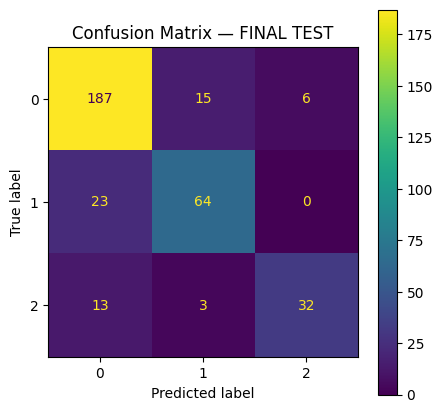

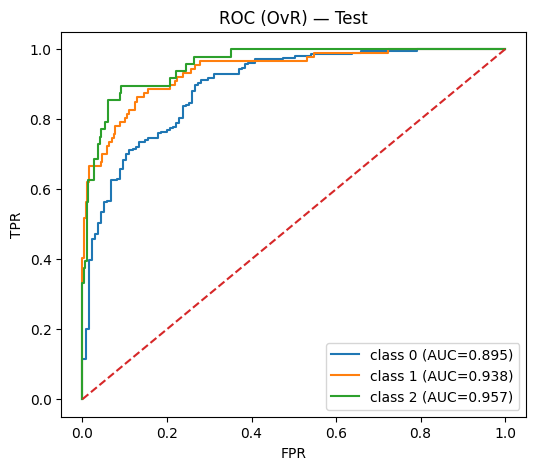

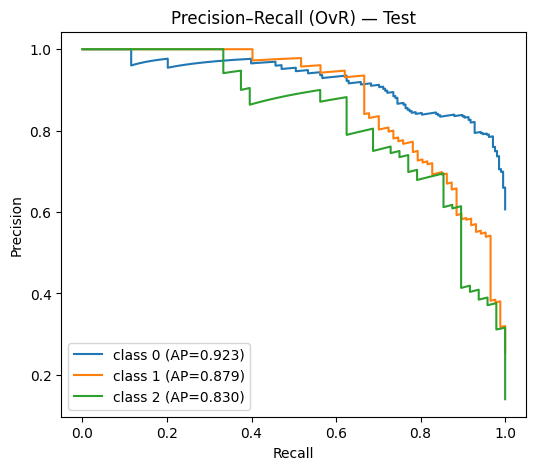

In [35]:
# Cell 13 — Final test metrics
y_test_probs = rf.predict_proba(X_test_s)
y_test_pred  = rf.predict(X_test_s)

print("=== FINAL TEST REPORT ===")
print(classification_report(y_test, y_test_pred, digits=4))

fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax)
ax.set_title("Confusion Matrix — FINAL TEST")
plt.show()

# Test ROC/PR
plt.figure(figsize=(6,5))
for c in range(n_classes):
    fpr, tpr, _ = roc_curve((y_test==c).astype(int), y_test_probs[:, c])
    plt.plot(fpr, tpr, label=f"class {c} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (OvR) — Test"); plt.legend()
plt.show()

plt.figure(figsize=(6,5))
for c in range(n_classes):
    prec, rec, _ = precision_recall_curve((y_test==c).astype(int), y_test_probs[:, c])
    ap = average_precision_score((y_test==c).astype(int), y_test_probs[:, c])
    plt.plot(rec, prec, label=f"class {c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (OvR) — Test"); plt.legend()
plt.show()


## Android Integration Checklist

- **Standardization:** Using `models/feature_scaler_train.pkl` for the **exact** means/stds in the Android `TFLiteEmotionInterpreter.java` (or load and embed values).
- **Feature order:** Must match the 10-feature contract documented in the preprocessing step.
- **ONNX outputs:** Expecting two outputs:
  - `output_label` (int64 class index `[0,1,2]`),
  - `output_probability` (`float[N,3]`).
- **Windowing:** The app should compute the same 30-sample window logic as training or feed raw samples into a buffer to derive the same 10 statistics.

---

## References (Scientific)

- Schmidt, P., et al. (2018). **Introducing WESAD: A Multimodal Dataset for Wearable Stress and Affect Detection.** *Proc. ICMI 2018*.  
- Breiman, L. (2001). **Random Forests.** *Machine Learning*, 45(1), 5–32.  
- Saito, T., & Rehmsmeier, M. (2015). **The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets.** *PLOS ONE*, 10(3): e0118432.  
- Niculescu-Mizil, A., & Caruana, R. (2005). **Predicting Good Probabilities with Supervised Learning.** *ICML 2005* (for calibration insight).

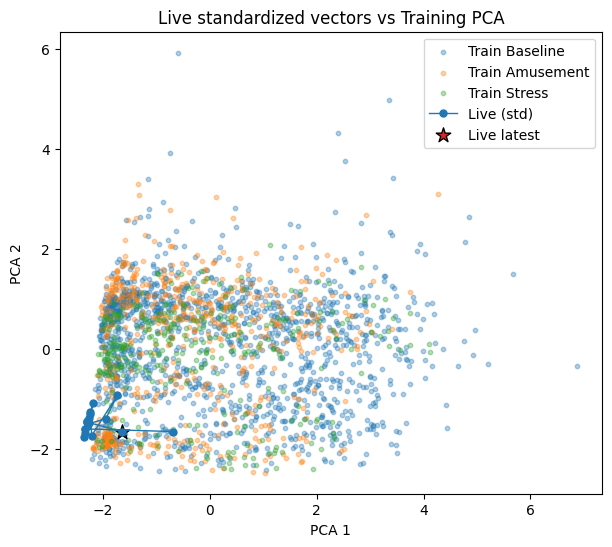


Last standardized 10-D vector:
[-0.2195 -0.7065 -4.0771  2.0222 -0.0338 -0.6545 -0.2173 -0.9404  0.6077
 -1.2822]

RF predictions for live standardized vectors: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# =========================================================
# Live debug: EITHER raw JSON (device logs) OR standardized 10-D vectors
# =========================================================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
import joblib

NB_DIR = Path.cwd()
SCALER_PATH = (NB_DIR / "../models/feature_scaler_train.pkl").resolve()
X_PATH      = (NB_DIR / "../preprocessed/X.npy").resolve()
Y_PATH      = (NB_DIR / "../preprocessed/y.npy").resolve()
RF_PATH     = (NB_DIR / "../models/rf_model.pkl").resolve()   # optional

# ---- choose input mode ----
USE_STANDARDIZED = True   
LIVE_LOG_PATH    = (NB_DIR / "../preprocessed/live_log.txt").resolve()  # used if USE_STANDARDIZED=False

# ---- if USE_STANDARDIZED=True, Vectors (one per line) here ----
LIVE_STD_STR = """
[-0.09583794, -0.9444702, -3.8908234, 2.521764, -0.033807617, -0.24126838, -0.20868345, 0.43920493, 0.7690837, -1.3424592]
[-0.13377635, -1.0082725, -4.027709, 2.525373, -0.033807617, -1.0681121, -0.8581461, -1.0851884, 0.34176418, -1.3431299]
[-0.1339371, -1.0097737, -4.0284286, 2.525373, -0.033807617, -1.068729, -0.8557826, -1.0847273, 0.34176418, -1.3512001]
[-0.13377637, -1.010024, -4.028908, 2.5199633, -0.033807617, -1.0692825, -0.85561365, -1.0862081, 0.6884983, -1.3512001]
[-0.13393712, -1.0105243, -4.027949, 2.5190578, -0.033807617, -1.0699321, -0.8545129, -1.0846838, 0.7089426, -1.3510633]
[-0.13329409, -1.0110247, -4.02699, 2.5181575, -0.033807617, -1.0712926, -0.8535228, -1.0848581, 0.7263049, -1.3509412]
[-0.12798916, -0.99250954, -4.0320244, 2.3792953, -0.033807617, -1.0594227, -0.8284545, -1.0850556, 1.1184813, -1.3520366]
[-0.1270246, -0.97574574, -4.0392165, 2.3531492, -0.033807617, -1.0714247, -0.83491886, -1.0837679, 0.6737887, -1.3501481]
[-0.12750688, -0.97224295, -4.0399356, 2.3432274, -0.033807617, -1.0666716, -0.8394969, -1.0847926, 0.7089387, -1.3498173]
[-0.12397025, -0.9532273, -4.0435314, 2.2999513, -0.033807617, -1.0554795, -0.8442878, -1.0883232, 1.692959, -1.3439323]
[-0.12075512, -0.94947433, -4.043532, 2.283717, -0.033807617, -1.05366, -0.8469576, -1.0907711, 0.9322492, -1.3452142]
[-0.1178615, -0.95547926, -4.0423326, 2.2503524, -0.033807617, -1.070139, -0.8549662, -1.0885806, 1.2482712, -1.3506479]
[-0.10596556, -0.9517262, -4.0449696, 2.2332227, -0.033807617, -0.93592554, -0.7666123, -1.0630164, 0.07649524, -1.3185943]
[-0.12461327, -0.8806678, -4.0550385, 2.1980577, -0.033807617, -0.70290136, -0.5206418, -1.0355387, 2.2267826, -1.3066388]
[-0.19775723, -0.8028539, -4.075895, 2.1196089, -0.033807617, -0.77036947, -0.62739515, -1.0440936, 1.118448, -1.347637]
[-0.21126074, -0.82136923, -4.0828476, 2.1024766, -0.033807617, -1.067106, -0.8541909, -1.0895898, 0.76908904, -1.3527627]
[-0.21093923, -0.82061845, -4.083566, 2.0889506, -0.033807617, -1.0664573, -0.85440516, -1.0935054, 0.11787094, -1.3523905]
[-0.2102962, -0.81661516, -4.0816483, 2.077228, -0.033807617, -1.0695239, -0.85785884, -1.0927045, 0.32399833, -1.3503928]
[-0.20981394, -0.8028539, -4.082847, 2.055589, -0.033807617, -1.0720989, -0.8205915, -1.0887889, 0.8440376, -1.3501278]
[-0.2194593, -0.7065248, -4.0770936, 2.022222, -0.033807617, -0.6545311, -0.2172775, -0.94041145, 0.6076702, -1.2822142]
""".strip()

# ---------------- core helpers ----------------
def parse_json_line(line: str):
    line = line.strip()
    if not line:
        return None
    try:
        return json.loads(line)
    except json.JSONDecodeError:
        s, e = line.find("{"), line.rfind("}")
        if s != -1 and e != -1:
            try: return json.loads(line[s:e+1])
            except json.JSONDecodeError: return None
        return None

def read_standardized_lines(s: str):
    vecs = []
    for line in s.splitlines():
        line = line.strip()
        if not line or not line.startswith("["): 
            continue
        arr = np.array(json.loads(line), dtype=np.float64)
        if arr.shape == (10,):
            vecs.append(arr)
    return np.vstack(vecs) if vecs else np.empty((0,10))

def read_raw_json_lines(path: Path):
    if not path.exists():
        raise FileNotFoundError(
            f"Live log file not found at {path}. "
            "Create it with one JSON per line, or switch USE_STANDARDIZED=True and paste vectors."
        )
    rows = []
    for line in path.read_text().splitlines():
        obj = parse_json_line(line)
        if not obj: 
            continue
        if int(obj.get("finger", 0)) != 1: 
            continue
        rows.append({
            "acc_x": float(obj.get("acc_x", np.nan)),
            "acc_y": float(obj.get("acc_y", np.nan)),
            "acc_z": float(obj.get("acc_z", np.nan)),
            "temp":  float(obj.get("temp",  np.nan)),
            "bvp":   float(obj.get("bvp",   np.nan)),
        })
    import pandas as pd
    return pd.DataFrame(rows)

# 1) load scaler & training arrays
scaler = joblib.load(SCALER_PATH)
means = np.asarray(scaler["means"], dtype=np.float64)
stds  = np.asarray(scaler["stds"],  dtype=np.float64)
feat_order = scaler.get("feature_order", [
    "acc_x_mean","acc_y_mean","acc_z_mean","temp_mean","bvp_mean",
    "acc_x_std","acc_y_std","acc_z_std","temp_std","bvp_std"
])
X_train = np.load(X_PATH)   # unscaled (N,10)
y_train = np.load(Y_PATH)   # (N,)

# standardize training
X_train_std = (X_train - means) / stds

# fit PCA
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)

# 2) get live standardized vectors
if USE_STANDARDIZED:
    live_std = read_standardized_lines(LIVE_STD_STR)
    if live_std.size == 0:
        raise ValueError("No standardized vectors parsed from LIVE_STD_STR. Paste one 10-D array per line.")
    live_pca = pca.transform(live_std)
else:
    # raw JSON path (not used here, but kept for completeness)
    df = read_raw_json_lines(LIVE_LOG_PATH)
    if df.empty:
        raise ValueError("No wearable (finger==1) samples in the live log.")
    # --- IMPORTANT ---
    # If ever we use raw logs here, must rebuild windowed features and standardize.
    # Skipped because we're providing standardized vectors already.
    raise NotImplementedError("Raw JSON path disabled; set USE_STANDARDIZED=True for your data.")

# 3) plot
labels = {0:"Baseline", 1:"Amusement", 2:"Stress"}
fig, ax = plt.subplots(figsize=(7,6))
for lab in [0,1,2]:
    m = (y_train == lab)
    if m.any():
        ax.scatter(X_train_pca[m,0], X_train_pca[m,1], s=10, alpha=0.35, label=f"Train {labels[lab]}")
ax.plot(live_pca[:,0], live_pca[:,1], marker='o', linewidth=1, markersize=5, label="Live (std)")
ax.scatter(live_pca[-1,0], live_pca[-1,1], s=120, marker='*', edgecolor='k', label="Live latest")
ax.set_xlabel("PCA 1"); ax.set_ylabel("PCA 2"); ax.set_title("Live standardized vectors vs Training PCA")
ax.legend(); plt.show()

print("\nLast standardized 10-D vector:")
print(np.round(live_std[-1], 4))

# 4) Classify with RF model if available
if RF_PATH.exists():
    rf = joblib.load(RF_PATH)
    preds = rf.predict(live_std)
    print("\nRF predictions for live standardized vectors:", preds)
else:
    print("\nNote: RF model not found at", RF_PATH)
